# Introduction

This churn prediction project is designed to address customer retention in the telecom industry. Leveraging a dataset with various customer attributes.

By utilizing machine learning techniques, it seeks to identify customers at risk of churning, enabling companies to take proactive measures to retain them. With the ability to predict churn, this project becomes a valuable tool for telecom companies, allowing them to tailor their strategies, improve customer satisfaction, and reduce customer turnover.

In [1]:
# Imports 
import pandas as pd 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier

In [2]:
# Functions
def unique_col_value(df: pd.DataFrame) -> None:
    """Display unique values for each categorical columns.

    Args:
        df (DataFrame): The DataFrame used to display unique values.
    """
    for col in df.select_dtypes('object').columns:
        print(f"{col :-<30} {df[col].unique()}")

def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray, idx: np.intp, label: str=None) -> None:
    """Plot the ROC curve with the best threshold based on G-mean value.

    Args:
        fpr (ndarray): The false positive rate array.
        tpr (ndarray): The true positive rate array.
        idx (intp): The index of the G-mean value.
        label (str, optional): The label for the plot.
            Defaults to None.
    """
    plt.figure(figsize=(12,5))
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], 'k--', label="NoSkill")
    plt.scatter(fpr[idx], tpr[idx], marker='o', c='C3', label="Best threshold", zorder=3)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="lower right")
    plt.show()

## Exploratory Data Analysis

In [3]:
# Read the data
df = pd.read_csv('churn_prediction.csv', dtype = {'gender' : str})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We have severals columns : 
- customerID : ID of customer
- gender : customer gender
- SeniorCitizen : whether the customer is a senoir citizen or not
- Partner : whether the customer has a partner or not
- Dependants : whether the customer has dependants or not
- tenure : number of months the customer has stayed with the company
- PhoneService : whether the customer has a phone service or not
- MultipleLines : whether the customer has multiple lines or not
- InternetService : customer's internet service provider
- OnlineSecurity : whether the customer has online security or not
- OnlieBackup : whether the customer has online backup or not
- DeviceProtection : whether the customer has device protection or not
- TechSupport : whether the customer has tech support or not
- StreamingTV : whether the customer has streaming TV or not
- StreamingMovies : whether the customer has streaming movies or not
- Contract : the contract term of the customer
- PaperlessBilling : whether the customer has paperless billing or not
- PaymentMethod : the customer's payment method
- MonthlyCharges : the amount charged to the customer monthly
- TotalCharges : the total amount charged to the customer
- Churn : whether the customer churned or not

First we don't need customerID columns, so we drop it. 

In [4]:
# Drop useless customerID column
df.drop('customerID', axis=1, inplace=True)

In [5]:
# Columns informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


It seems we don't have null values on our dataset, but when look closer dtypes columns, TotalCharges is an object columns. We will analyse why and convert it to float.
When we use pd.to_numeric, we have an error, because severals rows have " " as value, so we check these rows.

In [6]:
# Observation 
df[pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()].shape

(11, 20)

It represent less than 1% of our total shape, so we drop it. 

In [7]:
# Drop blank total charges
df = df[df['TotalCharges'] != " "]
df.shape

(7032, 20)

In [8]:
# Convert total charges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['TotalCharges'].dtypes

dtype('float64')

Now we have a lot of object columns, let's check them.

In [9]:
unique_col_value(df)

gender------------------------ ['Female' 'Male']
Partner----------------------- ['Yes' 'No']
Dependents-------------------- ['No' 'Yes']
PhoneService------------------ ['No' 'Yes']
MultipleLines----------------- ['No phone service' 'No' 'Yes']
InternetService--------------- ['DSL' 'Fiber optic' 'No']
OnlineSecurity---------------- ['No' 'Yes' 'No internet service']
OnlineBackup------------------ ['Yes' 'No' 'No internet service']
DeviceProtection-------------- ['No' 'Yes' 'No internet service']
TechSupport------------------- ['No' 'Yes' 'No internet service']
StreamingTV------------------- ['No' 'Yes' 'No internet service']
StreamingMovies--------------- ['No' 'Yes' 'No internet service']
Contract---------------------- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling-------------- ['Yes' 'No']
PaymentMethod----------------- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn------------------------- ['No' 'Yes']


When we have "No internet service", we can replace by No, as well as "No phone service". 

In [10]:
# Replace useless values
for string in ["No internet service", "No phone service"]:
    df.replace(string, "No", inplace=True)

# Check result
unique_col_value(df)

gender------------------------ ['Female' 'Male']
Partner----------------------- ['Yes' 'No']
Dependents-------------------- ['No' 'Yes']
PhoneService------------------ ['No' 'Yes']
MultipleLines----------------- ['No' 'Yes']
InternetService--------------- ['DSL' 'Fiber optic' 'No']
OnlineSecurity---------------- ['No' 'Yes']
OnlineBackup------------------ ['Yes' 'No']
DeviceProtection-------------- ['No' 'Yes']
TechSupport------------------- ['No' 'Yes']
StreamingTV------------------- ['No' 'Yes']
StreamingMovies--------------- ['No' 'Yes']
Contract---------------------- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling-------------- ['Yes' 'No']
PaymentMethod----------------- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn------------------------- ['No' 'Yes']


Now we can do binary encoding for yes/no columns as well as female/male column.

In [11]:
# Create a liste of yes/no columns
yes_no_col = []
for col in df.select_dtypes('object').columns: 
    if col in ["InternetService", "Contract", "PaymentMethod", "gender"]:
        continue
    else:
        yes_no_col.append(col)

# Binary encoding
for col in yes_no_col: 
    df[col].replace({"Yes": 1, "No": 0}, inplace=True)

# Check result 
for col in yes_no_col: 
    print(f"{col :-<30} {df[col].unique()}")

Partner----------------------- [1 0]
Dependents-------------------- [0 1]
PhoneService------------------ [0 1]
MultipleLines----------------- [0 1]
OnlineSecurity---------------- [0 1]
OnlineBackup------------------ [1 0]
DeviceProtection-------------- [0 1]
TechSupport------------------- [0 1]
StreamingTV------------------- [0 1]
StreamingMovies--------------- [0 1]
PaperlessBilling-------------- [1 0]
Churn------------------------- [0 1]


We use the same method for gender column.

In [12]:
# Binary encoding of gender columns
df['gender'].replace({'Female': 1, "Male": 0}, inplace=True)

# Check result 
for col in ["gender"]: 
    print(f"{col :-<30} {df[col].unique()}")

gender------------------------ [1 0]


The last object columns have more than two values, so it appropriate to use one hot encoding.

In [14]:
# One hot encoding
df_clean = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], dtype='int')
df_clean.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


Now our data is ready for graphical analysis.

First we analyze tenure and churn.

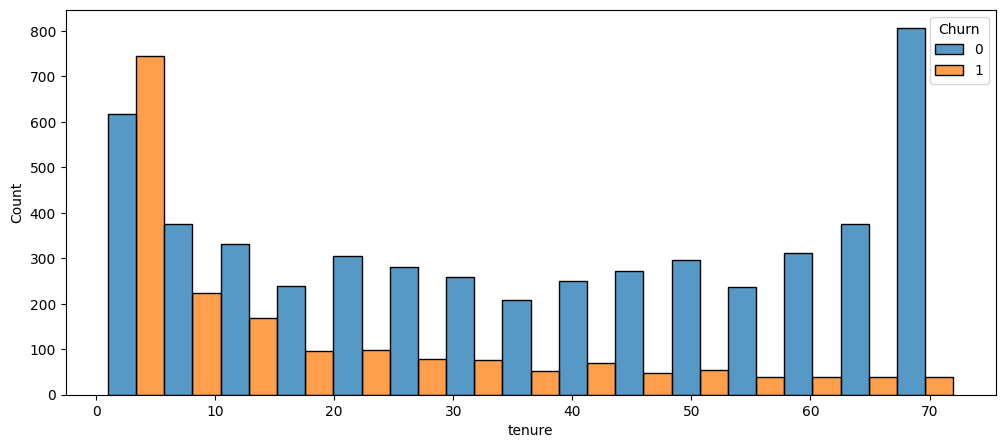

In [15]:
# Tenure analysis
plt.figure(figsize = (12,5))
sb.histplot(data=df_clean, x='tenure', hue='Churn', multiple='dodge')
plt.show()

This is very interesting, we can see that the higher the tenure the lower the churn. So tenure may be an important feature for classification.

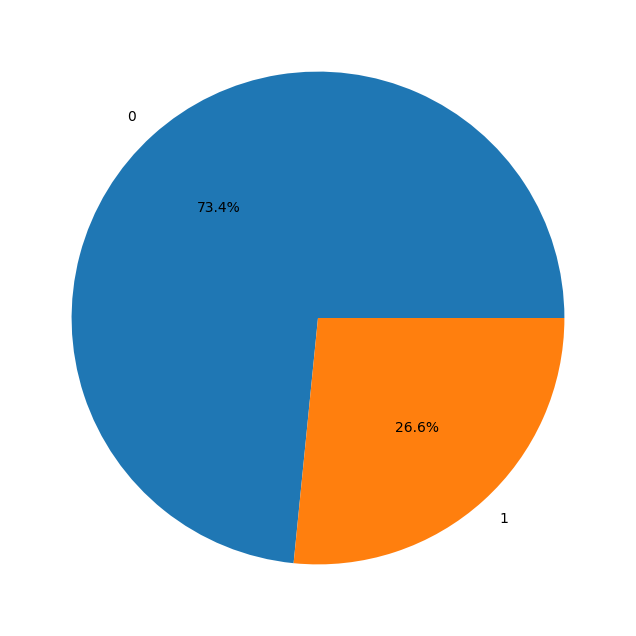

In [16]:
# Target balance
plt.figure(figsize = (12,8))
plt.pie(df_clean['Churn'].value_counts(), labels=df_clean['Churn'].unique(), autopct="%1.1f%%")
plt.show()

We have a large majority of staying customers. So it is an imbalanced dataset.

To achieve good result during classification, we will use over sampling algorithm like SMOTE. It enables to generate samples from the minority class, to have a balanced dataset.

Another important feature could be the charges, more specifically the monthly and total charges.

<Figure size 1200x800 with 0 Axes>

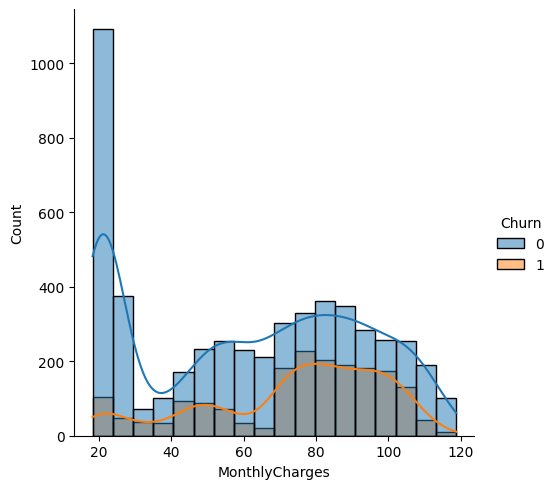

<Figure size 1200x800 with 0 Axes>

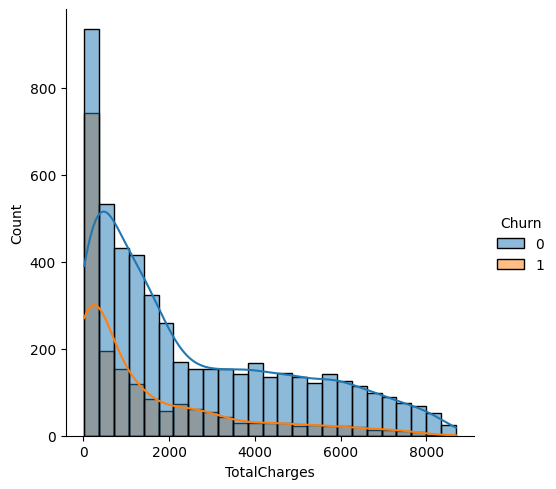

In [22]:
# Charges analysis
for col in ['MonthlyCharges', 'TotalCharges']: 
    plt.figure(figsize = (12,8))
    sb.displot(data=df_clean, x=col, kde=True, hue='Churn')
    plt.show()

We can see differences between the two classes, but there still a large overlap. Monthly charges could be more interesting than total charges, even if we will keep these two features.

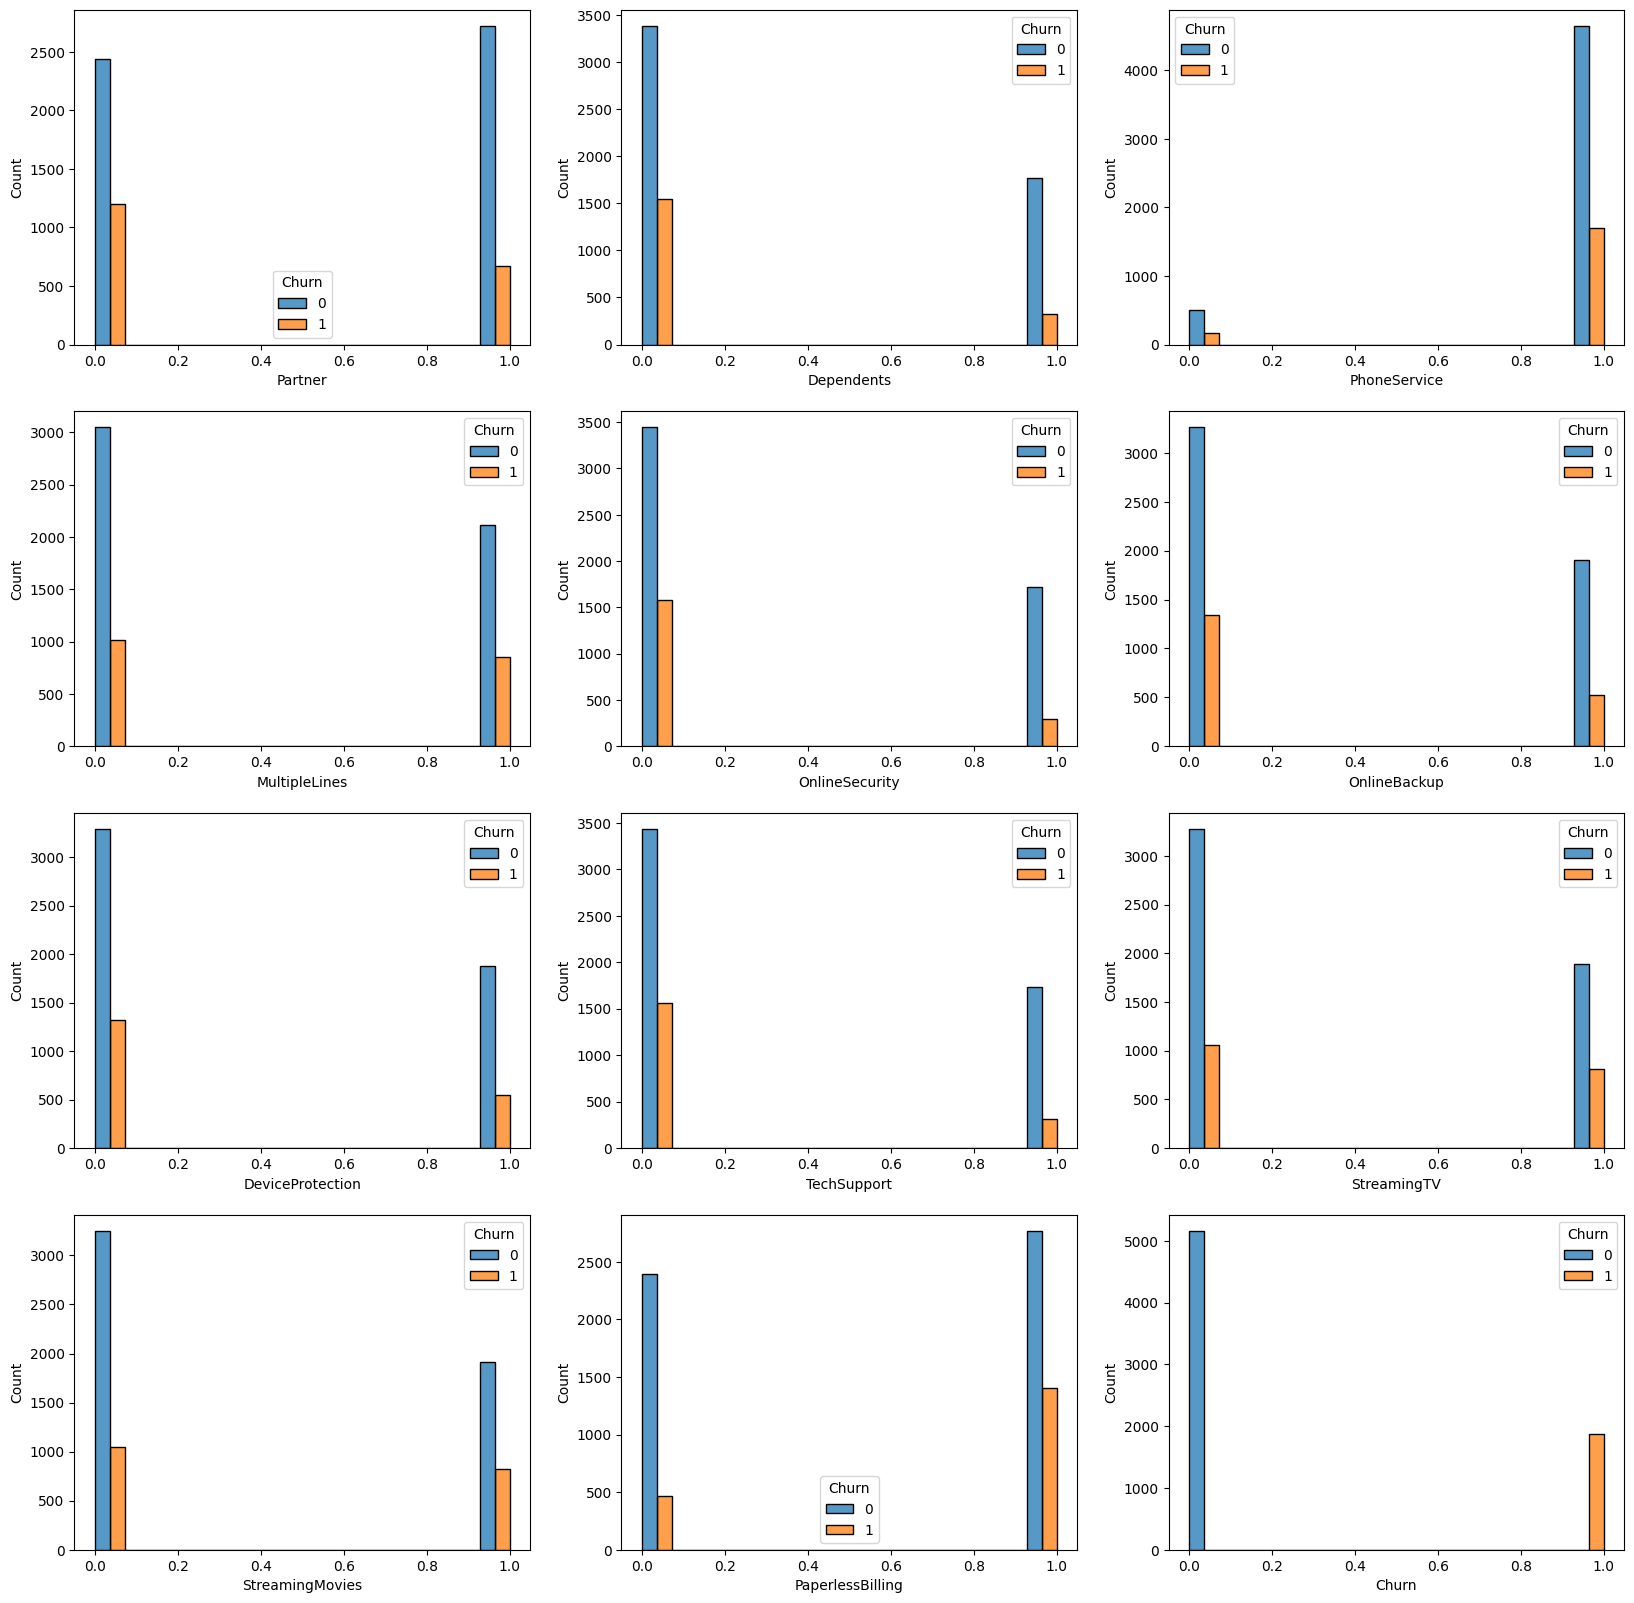

In [23]:
#Churn proportion on over columns
plt.figure(figsize=(20,20))
for index, col in enumerate(yes_no_col): 
    plt.subplot(4, 3, index+1)
    sb.histplot(data=df_clean, x=col, hue='Churn', multiple='dodge')
plt.show()

Here, generally, we can see that when the customer take an option, there is less churn.

## Preprocessing

First of all, we can split our data in train and test set.

In [24]:
# Split the target and predictor variables
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

# Split into train and test set
(
    X_train,
    X_test,
    y_train,
    y_test
) = train_test_split(X, y, test_size=0.3, random_state=42)

# Shape verification 
for yt, name in zip([y_train, y_test], ["train", "test"]): 
    print(f"Shape of {name} set is {yt.shape}")

Shape of train set is (4922,)
Shape of test set is (2110,)


The second operation is over sampling. We use SMOTE algorithm, for Synthetic Minority Oversampling Technique.  
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [25]:
# Dealing whith imbalanced dataset
sm = SMOTE()
print("Original dataset shape:", Counter(y_train))
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print("Resampled dataset shape:", Counter(y_train_smote))

Original dataset shape: Counter({0: 3614, 1: 1308})
Resampled dataset shape: Counter({1: 3614, 0: 3614})


The next step is modelization, so we are in a supervised learning task, more specifically in a classification task. There are a lot of algorithm for classification problem. But we will use XgBoost algorithm.

## Modeling

Boosting refers to any ensemble method that can combine weak learners into a strong learner. The general idea of most boosting methods is to train predictorssequentially, each trying to correct its predecesor.

XgBoost for eXtrem Gradient Boosting is a very popular algorithm. As said before, XgBoost works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, this method tries to fit the new predictor to the residual errors made by the previous predictor. The residual errors is the distance between the sample and the fit.

Since we are in a binary classification task, we initialize the objective function as binary logistic and the evaluation metric as logloss.  
Logloss is defined as the negative log-likelihood of a logistic model that returns probabilities for its training data.

We will compare the result with and without SMOTE using ROC AUC score, which more representative than accuracy when dealing with imbalanced dataset.

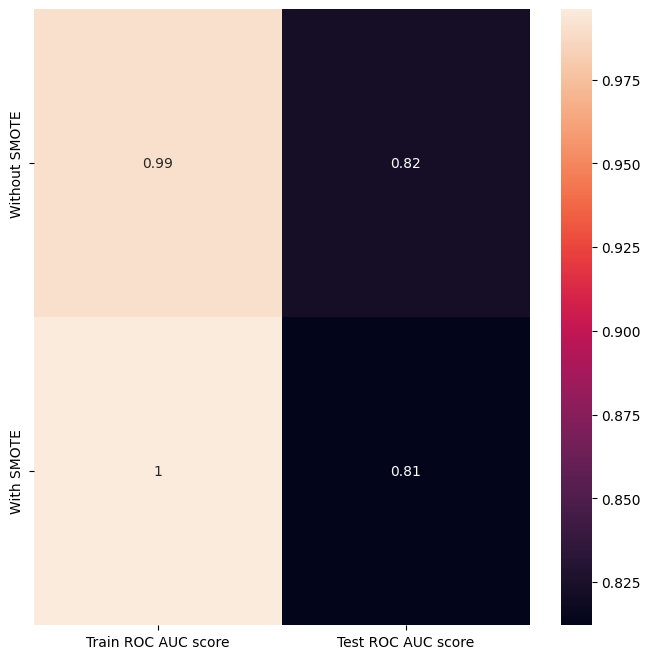

In [26]:
# Define based XGBoost model
model = XGBClassifier(objective="binary:logistic", eval_metric='logloss')
model_smote = XGBClassifier(objective="binary:logistic", eval_metric='logloss')

# Fit the models
model.fit(X_train, y_train)
model_smote.fit(X_train_smote, y_train_smote)

# Get ROC AUC score
train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
train_score_smote = roc_auc_score(y_train_smote, model_smote.predict_proba(X_train_smote)[:, 1])
test_score_smote = roc_auc_score(y_test, model_smote.predict_proba(X_test)[:, 1])

# Create a dataframe to display result
scores = {
    "Train ROC AUC score": [train_score, train_score_smote], 
    "Test ROC AUC score": [test_score, test_score_smote]
}
index = ["Without SMOTE", "With SMOTE"]
df_result = pd.DataFrame(data=scores, index=index)

plt.figure(figsize=(8,8))
sb.heatmap(df_result, annot=True)
plt.show()

We can see that there is no difference between the classifications with or without SMOTE. It can be explained by the fact that SMOTE struggle with overlapping classes. Since the KNN algorithm behind will just add more overlap, it can be consider as noise. In other words, we will continue with the train set withou SMOTE and try to penalize errors made on the majority class.

Nevertheless, we can see that we are overfitting our data. So, to better understand our ressult on the test set, we can use classification report. It give us the precision, the recall and the f1 score for each class.

In [27]:
# Classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1549
           1       0.62      0.52      0.57       561

    accuracy                           0.79      2110
   macro avg       0.73      0.70      0.72      2110
weighted avg       0.78      0.79      0.78      2110



Even if we have very good result, our performance decrease considerably on prediction of the class 1. This due to the imbalanced dataset. 
But we can improve our result by tuning XgBoost algorithm, by making the classifier more simple to generalize better, or adding some penalty to bad classification on class 1 for example.

### Optimization 

To tune an XgBoost model, we define two hyper-parameters types.  

Tree-based parameters :  
- max_depth
- min_child_weight
- colsample_bytree
- subsample

Regularization parameters :
- learning_rate
- n_estimators
- scale_pos_weight

We use GridSearchCV which search for any combination of parameters using cross-validation to ensure result. But since we have imbalanced dataset, we will use StratifiedKFold cross validation method. 

Stratified cross validation (or StratifiedKFold) is a variation of the base cross validation technique avaliable in sklearn (KFold), which return stratified fold: each set contains approximately the same percentage of samples of each target class as the complete set. So StratifiedKFold keeps the class proportions the same across all of the folds, which is vital for maintaining a representative subset of our data set.

We begin by tree-based parameters, once fixed, we tune regularization parameters.

In [28]:
# Define parameters to optimize
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.4, 0.3, 0.2],
    'scale_pos_weight': [None, 3, 10] 
}

# Optimization
grid_search = GridSearchCV(
    XGBClassifier(
        objective="binary:logistic", eval_metric='logloss',
        max_depth=1, min_child_weight=10, subsample=0.95,
        colsample_bytree=0.95,
    ), 
    param_grid=params, 
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3)
)
grid_search.fit(X_train, y_train)

# Assign the best model  
model = grid_search.best_estimator_

print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.2, 'n_estimators': 100, 'scale_pos_weight': None}
0.8521084274939402


We have now tuned our model, and we can see that the ROC AUC score using StratifiedKFold cross validation is around our previous test score. But as training score, it is more representative of our result than before.

We can check our result on the test set.

In [29]:
# Predictions probabilities
y_proba = model.predict_proba(X_test)

# Score
print(f"Test score : {roc_auc_score(y_test, y_proba[:, 1])}")

Test score : 0.8411930415689957


We define our model we the best combination of parameters, which have a ROC AUC score of 84%. This is not much better than without parameters optimization, but it's always a good thing.

Another ways to visualize our result is to use ROC curve analysis and confusion matrix.

In [30]:
# Get y_scores
y_scores = model.predict_proba(X_test)
y_scores = y_scores[:, 1]

# ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# G-mean score
gmeans = np.sqrt(tpr * (1-fpr))
idx = np.argmax(gmeans)

The receiver operating characteristique (ROC) curve is another common tool used with binary classifiers. It plots the true positive rate (TPR) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive and the TPR is the ratio of positive instance that are correctly classified as positive.  
In fact the ROC curve plot the sensivity (recall) versus 1 - specifity (true negative rate). 

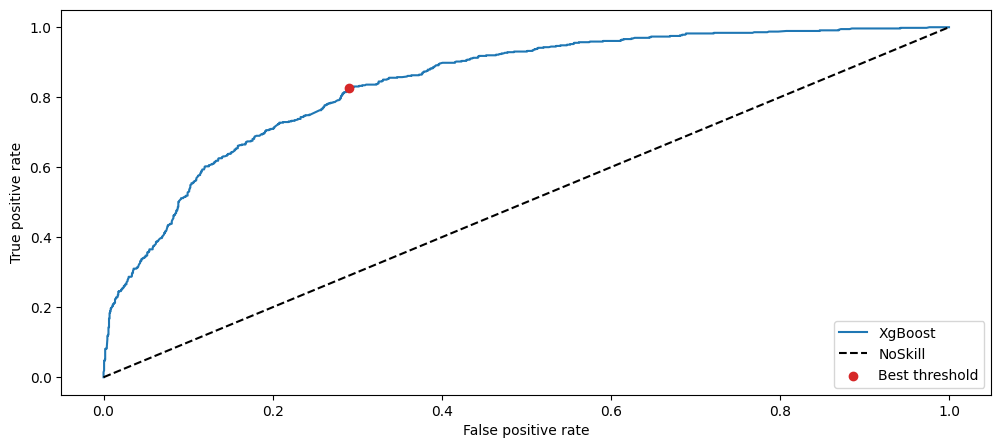

Best threshold = 0.276 with G-mean score = 0.766


In [36]:
# Visualize ROC curve
plot_roc_curve(fpr, tpr, idx, "XgBoost")
print(f"Best threshold = {thresholds[idx]:.3f} with G-mean score = {gmeans[idx]:.3f}")

We can see that we have a roughly good curve, which tell us that the model is correct. Then, the best threshold is arroung 0.318. So if we want, we can get the probability score for each prediction made by the model and apply this threshold rather the default (0.5).  
But we will keep the default and use confusion matrix to see our result on the test set first and compare it with the best threshold.

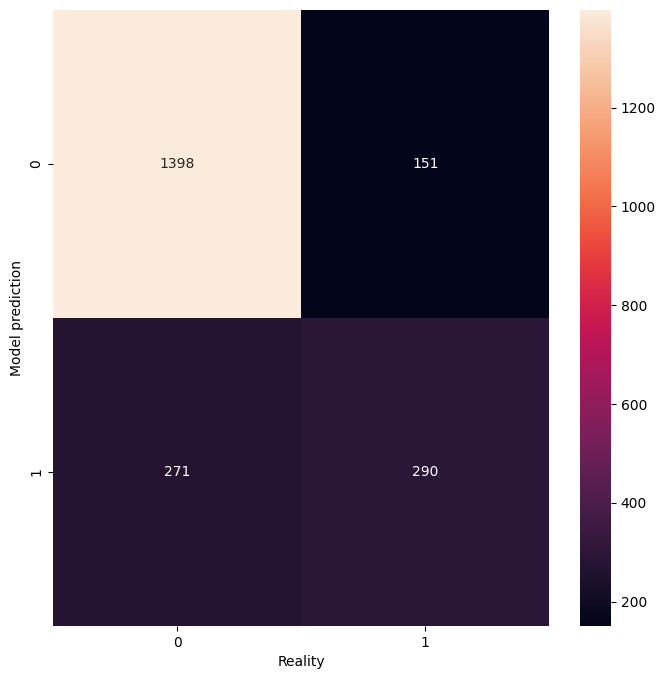

In [37]:
# Prediction 
y_pred = model.predict(X_test)

#Confusion matrix
plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()

We can see that we have very good result for class 0, but the model continue to struggle a lot on the class 1.

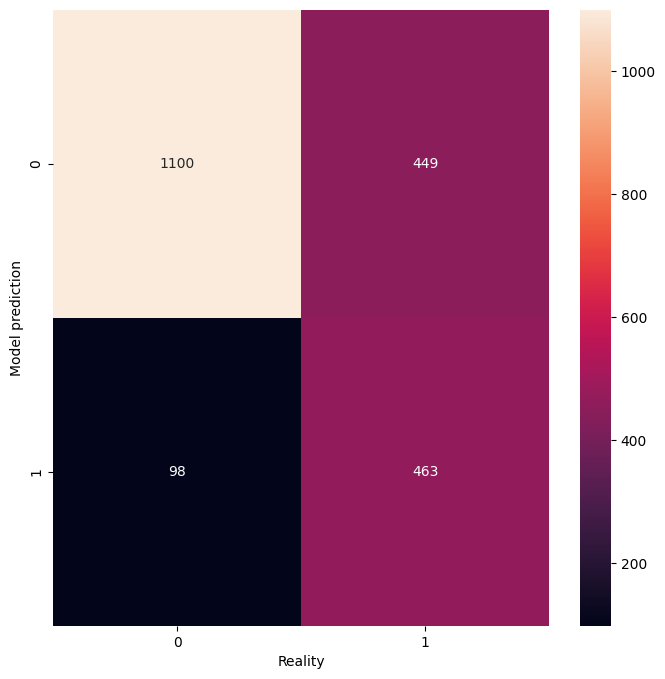

In [38]:
# Define the threshold
threshold = thresholds[idx]
# Prediction
y_proba = model.predict_proba(X_test)
y_pred = np.where(y_proba[:, 1] > threshold, 1, 0)

# Confusion matrix
plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()

Using this threshold, we improve our result, but at the cost of false positive errors.

## Conclusion

To conclude, we see in this project two main points. SMOTE algorithm for imbalanced dataset, and XgBoost algorithm for boosting method.  
First we try to use SMOTE to create synthetic samples of our minority class. But the result were insufficient.
So we use eXtrem Gradient Boosting algorithm for binary classification without SMOTE as preprocessing part. XgBoost may be a little diffcult to tune but is an extremely fast and powerfull method. 

We achieve some good result and visualize it with ROC curve and confusion matrix. Which are both good tools for result analysis.

Finally we analyzed the best threshold to improve our result of true negative rate, but it decrease our result of false positive rate, which is not a big issue since in this case. 